## Adadelta——从零开始

我们在“RMSProp——从零开始”一节中描述了，RMSProp针对Adagrad在迭代后期可能较难找到有用解的问题，对小批量随机梯度按元素平方项做指数加权移动平均而不是累加。另一种应对该问题的优化算法叫做Adadelta。有意思的是，它没有学习率超参数。

### Adadelta算法
Adadelta算法也像RMSProp一样，使用了小批量随机梯度按元素平方的指数加权移动平均变量$\boldsymbol{s}$，并将其中每个元素初始化为0。 给定超参数$\rho$且$0 \leq \rho < 1$， 在每次迭代中，RMSProp首先计算小批量随机梯度$\boldsymbol{g}$，然后对该梯度按元素平方项$\boldsymbol{g} \odot \boldsymbol{g}$做指数加权移动平均，记为$\boldsymbol{s}$：

$\boldsymbol{s} \leftarrow \rho \boldsymbol{s} + (1 - \rho) \boldsymbol{g} \odot \boldsymbol{g}$.

然后，计算当前需要迭代的目标函数自变量的变化量$\boldsymbol{g}^\prime$：

$\boldsymbol{g}^\prime \leftarrow \frac{\sqrt{\Delta\boldsymbol{x} + \epsilon}}{\sqrt{\boldsymbol{s} + \epsilon}}   \odot \boldsymbol{g},$

其中$\epsilon$是为了维持数值稳定性而添加的常数，例如$10^−5$。和Adagrad与RMSProp一样，目标函数自变量中每个元素都分别拥有自己的学习率。上式中$\Delta\boldsymbol{x}$初始化为零张量，并记录$\boldsymbol{g}^\prime$按元素平方的指数加权移动平均：

$\Delta\boldsymbol{x} \leftarrow \rho \Delta\boldsymbol{x} + (1 - \rho) \boldsymbol{g}^\prime \odot \boldsymbol{g}^\prime.$

同样地，最后的自变量迭代步骤与小批量随机梯度下降类似：

$\boldsymbol{x} \leftarrow \boldsymbol{x} - \boldsymbol{g}^\prime.$

### Adadelta的实现
Adadelta的实现很简单。我们只需要把上面的数学公式翻译成代码。


In [45]:
def adadelta(params, grads, sqrs, deltas, rho, batch_size):
    for param, grad, sqr, delta in zip(params, grads, sqrs, deltas):
        sqr[:] = rho * sqr + (1 - rho) * np.multiply(grad, grad)
        cur_delta = np.multiply(np.sqrt(delta + 1e-5) / np.sqrt(sqr + 1e-5), grad)
        delta[:]= rho * delta + (1 - rho) * np.multiply(cur_delta, cur_delta)
        param[:] -= cur_delta
    return params, sqrs, delta

## 实验
首先，导入本节中实验所需的包。

In [46]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import sys
import numpy as np
import random

sys.path.append('..')

实验中，我们以之前介绍过的线性回归为例。设数据集的样本数为1000，我们使用权重w为[2, -3.4]，偏差b为4.2的线性回归模型来生成数据集。该模型的平方损失函数即所需优化的目标函数，模型参数即目标函数自变量。

In [47]:
# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = np.random.normal(scale=1, size=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += 0.01 * np.random.normal(scale=1, size=y.shape)

# 初始化模型参数。
def init_params():
    w = np.random.normal(scale=1, size=(num_inputs, 1))
    b = np.zeros((1,))
    sqrs = []
    deltas = []
    params = [w, b]
    for param in params:
        sqrs.append(np.zeros(param.shape))
        deltas.append(np.zeros(param.shape))
    return params, sqrs, deltas

# 构造迭代器。
def data_iter(batch_size):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for batch_i, i in enumerate(range(0, num_examples, batch_size)):
        j = np.array(idx[i: min(i + batch_size, num_examples)])
        yield batch_i, X[j], y[j]

# 线性回归模型。
def net(X, w, b):
    return np.dot(X, w) + b

# 损失函数。
def square_loss(yhat, y):
    return (yhat - np.reshape(y, yhat.shape)) ** 2 / 2

def cal_grad(yhat, y, X):
    grad_w = np.expand_dims(np.array([-np.dot((yhat - np.reshape(y, yhat.shape)).T, X[:, 0]), -np.dot((yhat - np.reshape(y, yhat.shape)).T, X[:, 1])]), axis=1)
    #grad_w = np.array([-np.dot((yhat - np.reshape(y, yhat.shape)).T, X[:, 0])])
    grad_b = -np.sum((yhat - np.reshape(y, yhat.shape)))
    return [grad_w, grad_b]

优化函数optimize与“梯度下降和随机梯度下降——从零开始”一节中的类似。

In [56]:
import matplotlib as mpl

import matplotlib.pyplot as plt

def train(batch_size, rho, epochs, period):
    [w, b], sqrs, deltas = init_params()
    print w
    print b
    total_loss = [np.mean(square_loss(net(X, w, b), y))]
    # 注意epoch从1开始计数。
    for epoch in range(1, epochs + 1):
        # 学习率自我衰减。
        for batch_i, data, label in data_iter(batch_size):
            output = net(data, w, b)
            loss = square_loss(output, label)
            grad =  cal_grad(label, output, data)
            [w, b], sqrs, delta = adadelta([w, b], grad, sqrs, deltas, rho, batch_size)
            if batch_i * batch_size % period == 0:
                total_loss.append(
                    np.mean(square_loss(net(X, w, b), y)))
        print("Batch size %d, Epoch %d, loss %.4e" %
              (batch_size, epoch, total_loss[-1]))
    print('w:', np.reshape(w, (1, -1)),
          'b:', b, '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    mpl.rcParams['figure.figsize'] = 3.5, 2.5
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

最终，优化所得的模型参数值与它们的真实值较接近。



[[-0.68713997]
 [-1.9440547 ]]
[0.]
Batch size 10, Epoch 1, loss 5.0109e-05
Batch size 10, Epoch 2, loss 4.9361e-05
Batch size 10, Epoch 3, loss 4.9053e-05
('w:', array([[ 2.00079787, -3.40016449]]), 'b:', array([4.20038855]), '\n')


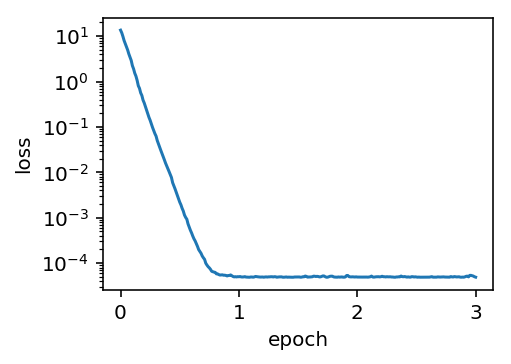

In [57]:
train(batch_size=10, rho=0.9999, epochs=3, period=10)
